# <font color=Aqua> **Tech Challenge - Fase 2 - Time Series**

**********************************************************

# <font color=Aqua> Problema Proposto



Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado. Você precisará demonstrar para o time de investimentos:
* O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
* Justificar a técnica utilizada;
* Atingir uma acuracidade adequada (acima de 70%).

A fonte para esse trabalho foi obtido por meio do site da investing:

https://br.investing.com/indices/bovespa-historical-data

# <font color=Aqua> Análise Exploratória dos Dados

Importação de Bibliotecas e Modelos:

In [11]:
!pip install statsforecast
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
# BIBLIOTECAS:
# Análise a Manipulação de Dados:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import statsmodels.api as sm

# MODELOS:
# Análise de Séries Temporais:
from statsmodels.tsa.seasonal import seasonal_decompose # Decomposição da Série Temporal
from statsmodels.tsa.stattools import adfuller # Teste de Dickey-Fuller
from statsmodels.tsa.stattools import acf, pacf # Análise de Autocorrelação e Autocorrelação Parcial
from statsforecast import StatsForecast

# ARIMA:
from statsmodels.tsa.arima.model import ARIMA

# Naive (Baseline) e Seasonal Naive (Naive com Sazonalidade):
from statsforecast.models import Naive, SeasonalNaive

# Prophet:
from prophet import Prophet

# Métrica de Erro:
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='white')
%matplotlib inline

In [13]:
years_analyzed = list(range(2020, 2024))

In [14]:
def data_import(csv_file_path : str):
    return pd.read_csv(csv_file_path, sep=",")

In [15]:
data_ibovespa = {}

for year in years_analyzed:
    data_ibovespa[year] = data_import(f'../data/Dados Históricos - Ibovespa {year}.csv')
    print(year)

2020
2021
2022
2023


In [16]:
grouped_data_ibovespa = pd.concat(data_ibovespa, ignore_index=True)

grouped_data_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12/30/2020,"119,017","119,410","120,150","118,919",8.24M,-0.33%
1,12/29/2020,"119,409","119,130","119,861","118,750",6.77M,0.24%
2,12/28/2020,"119,124","117,806","119,213","117,805",7.17M,1.12%
3,12/23/2020,"117,807","116,636","118,311","116,636",6.48M,1.00%
4,12/22/2020,"116,636","115,825","116,903","115,648",6.95M,0.70%


Nosso DataFrame contém as seguintes colunas:

* Data: Intervalo de tempo (diário)
* Último: Valor de fechamento do Índice Bovespa
* Abertura: Valor de abertura do Índice Bovespa
* Máxima: Valor máximo atingido pelo Índice Bovespa no dia
* Mínima: Valor mínimo atingido pelo Índice Bovespa no dia
* Vol.: Volume negociado do Índice Bovespa
* Var%: Variação percentual diária do Índice Bovespa

In [17]:
grouped_data_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      994 non-null    object
 1   Último    994 non-null    object
 2   Abertura  994 non-null    object
 3   Máxima    994 non-null    object
 4   Mínima    994 non-null    object
 5   Vol.      994 non-null    object
 6   Var%      994 non-null    object
dtypes: object(7)
memory usage: 54.5+ KB


Foi necessário tratar o DataFrame, convertendo os valores numéricos e as datas:

In [18]:
grouped_data_ibovespa['Data'] = pd.to_datetime(grouped_data_ibovespa['Data'], format='%m/%d/%Y')

cols_to_convert_float = ['Último', 'Abertura', 'Máxima', 'Mínima']

for col in cols_to_convert_float:
    grouped_data_ibovespa[col] = grouped_data_ibovespa[col].str.replace(',', '').astype(float)

grouped_data_ibovespa['Var%'] = grouped_data_ibovespa['Var%'].str.replace('%', '').astype(float)

In [19]:
grouped_data_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      994 non-null    datetime64[ns]
 1   Último    994 non-null    float64       
 2   Abertura  994 non-null    float64       
 3   Máxima    994 non-null    float64       
 4   Mínima    994 non-null    float64       
 5   Vol.      994 non-null    object        
 6   Var%      994 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 54.5+ KB


In [20]:
all_in_millions = grouped_data_ibovespa['Vol.'].str.contains('M').all()

print(f"Todos os volumes estão em milhões? {'Sim' if all_in_millions else 'Não'}")

Todos os volumes estão em milhões? Sim


In [21]:
grouped_data_ibovespa['Vol.'] = grouped_data_ibovespa['Vol.'].str.replace('M', '').astype(float) * 1e6

In [22]:
grouped_data_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      994 non-null    datetime64[ns]
 1   Último    994 non-null    float64       
 2   Abertura  994 non-null    float64       
 3   Máxima    994 non-null    float64       
 4   Mínima    994 non-null    float64       
 5   Vol.      994 non-null    float64       
 6   Var%      994 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 54.5 KB


In [23]:
grouped_data_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2020-12-30,119017.0,119410.0,120150.0,118919.0,8240000.0,-0.33
1,2020-12-29,119409.0,119130.0,119861.0,118750.0,6770000.0,0.24
2,2020-12-28,119124.0,117806.0,119213.0,117805.0,7170000.0,1.12
3,2020-12-23,117807.0,116636.0,118311.0,116636.0,6480000.0,1.00
4,2020-12-22,116636.0,115825.0,116903.0,115648.0,6950000.0,0.70


Resultado: Feito, analisando o valor atual da ação que é de 124.307,83 na data de hoje (27/06/2024 23:33), as inforçãos estão no formato correto e com valores que aparecentemente estão certo na grandesa correta.

**************************************************

Com o DataFrame tratado, agora é possível elaborar as previsões diárias do valor de fechamento. Portanto, trabalharemos com dados em um intervalo de tempo diário, e nossa variável alvo será 'Último'. Para isso utilizaremos o campo de data como índice:

In [24]:
df_ibv_fecha = grouped_data_ibovespa[['Data', 'Último']]
df_ibv_fecha.columns = ['data', 'fechamento']

In [25]:
df_ibv_fecha.dtypes

data          datetime64[ns]
fechamento           float64
dtype: object

In [26]:
df_ibv_fecha = df_ibv_fecha[['data', 'fechamento']].set_index('data').sort_index()
df_ibv_fecha.head()

,fechamento
data,
2020-01-02,118573.0
2020-01-03,117707.0
2020-01-06,116878.0
2020-01-07,116662.0
2020-01-08,116247.0


#<font color=cyan> Análise de Série Temporal

A análise de série temporal é um método estatístico para analisar dados coletados ao longo do tempo, identificando padrões, tendências, ciclos e sazonalidades, e fazendo previsões futuras com base em dados históricos. Entre os principais ítens das Séries Temporais, temos:

* Tendência: Direção geral dos dados (crescente, decrescente, estável).
* Sazonalidade: Padrões que se repetem regularmente (diariamente, semanalmente, etc.).
* Ciclo: Flutuações irregulares influenciadas por fatores externos.
* Ruído: Variações aleatórias sem padrão específico.

Como pode ser observado, inicialmente temos elaborado logo abaixo os valores de Fechamento do índice Ibovespa.

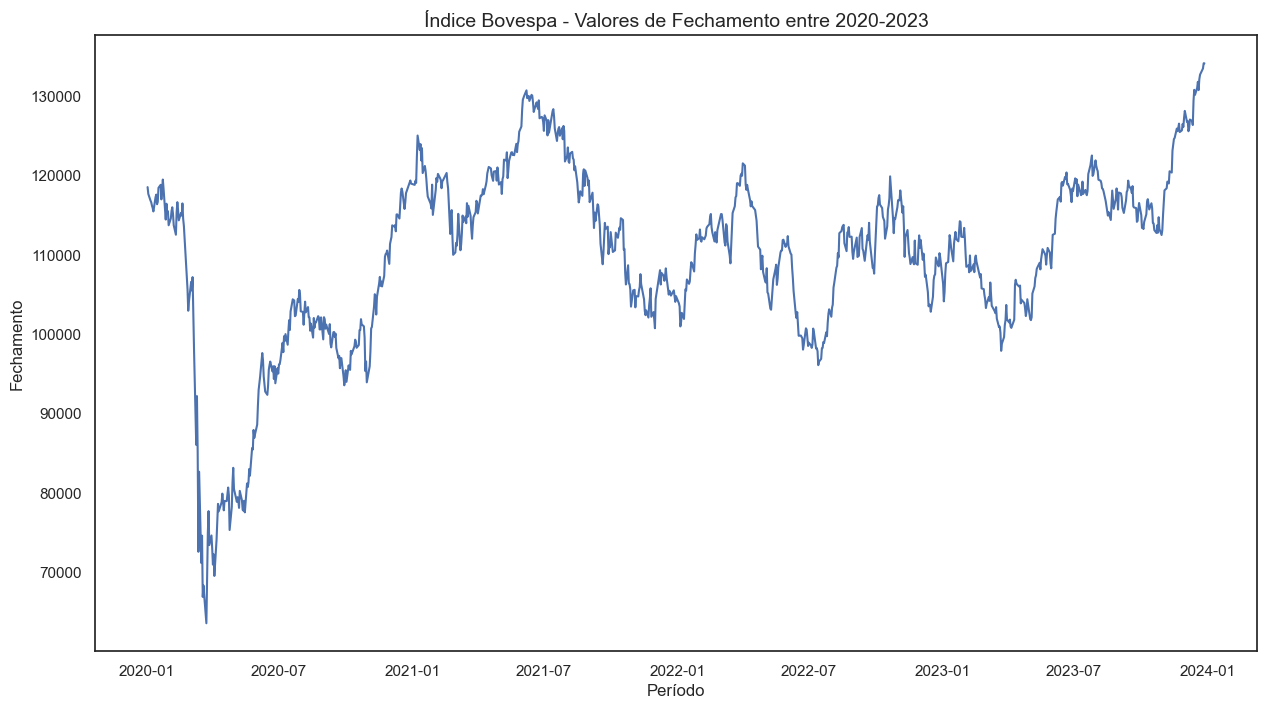

In [27]:
plt.figure(figsize = (15,8))

plt.plot(df_ibv_fecha.index, df_ibv_fecha.fechamento)
plt.title('Índice Bovespa - Valores de Fechamento entre 2020-2023', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)

plt.show()

Observações:

EXPLICAR QUAIS AS POSSÍVEIS CAUSAS DE QUEDA E SUBIDA

#<font color=cyan> Decomposição da Série

A decomposição de séries temporais é usada para separar os diferentes componentes que influenciam os dados ao longo do tempo, facilitando a análise e a modelagem. Sendo os principais ítens: **Tendência** (direção geral dos dados ao longo do tempo), **Sazonalidade** (padrões que se repetem em intervalos regulares) e **Resíduos** (parte dos dados não explicada pela tendência e sazonalidade).

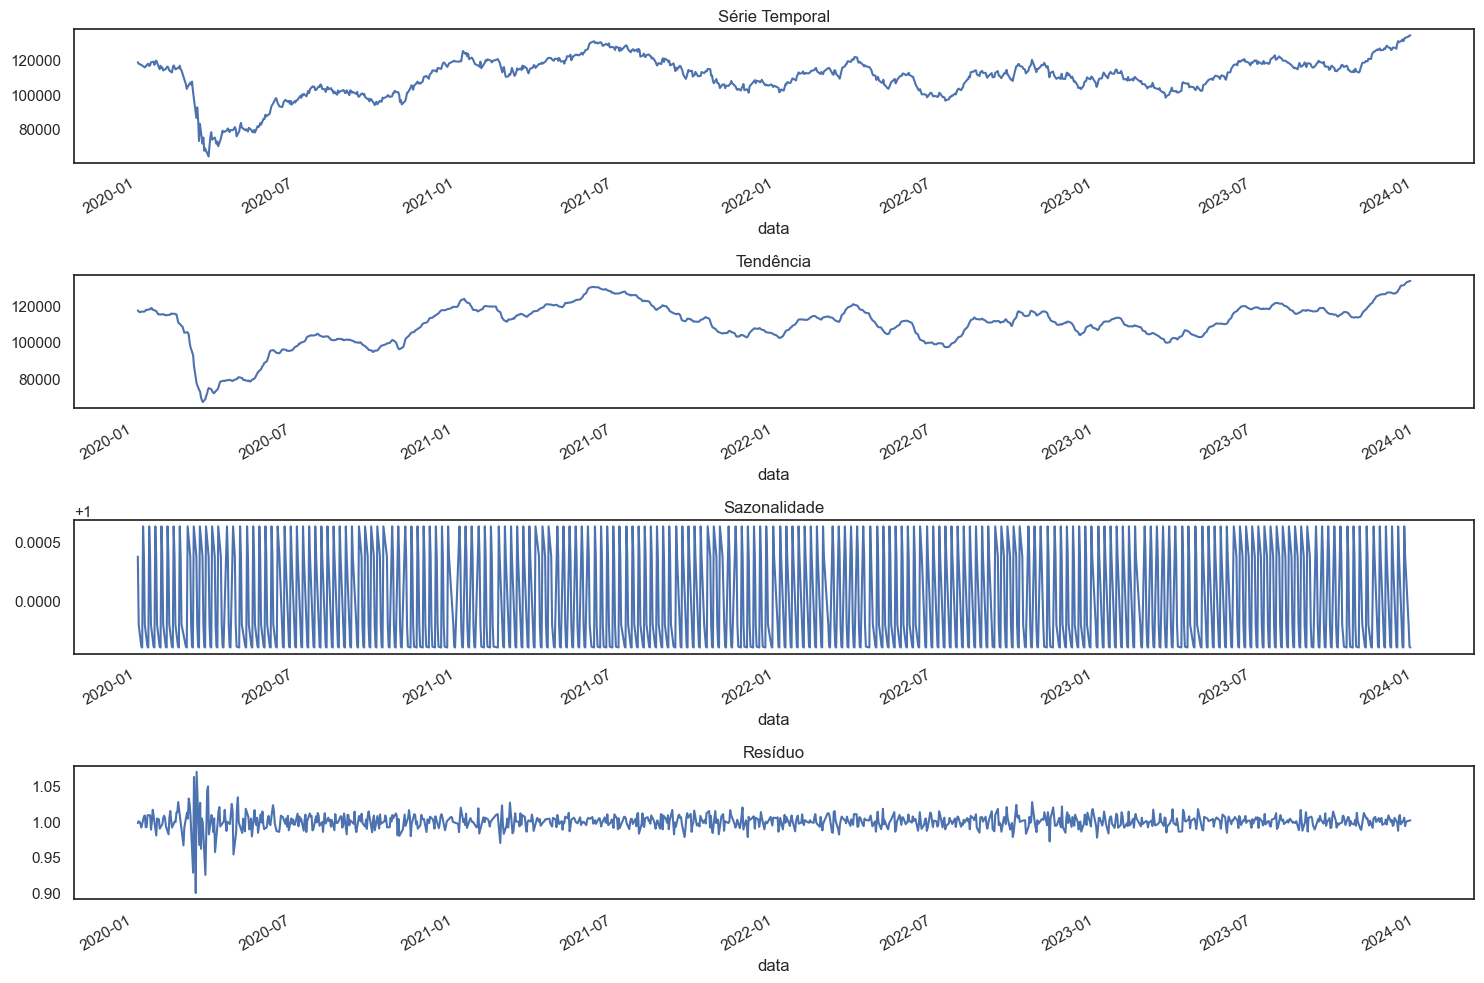

In [28]:
# Aplicação da Decomposição
resultados = seasonal_decompose(df_ibv_fecha['fechamento'], model='multiplicative', period=5)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

# Série Temporal - Origem
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Temporal')

# Tendência
resultados.trend.plot(ax=ax2)
ax2.set_title('Tendência')

# Sazonalidade
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')

# Resíduos
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')

plt.tight_layout()

Observações:
* Observa-se que a **tendência** da série é semelhante ao padrão observado na série temporal original, sem indicar uma tendência clara em uma direção específica

* A **sazonalidade** é difícil de ser observada, uma vez que estamos lidando com índices econômicos que variam diariamente, tornando a identificação de padrões repetitivos bastante complexa.

* Quanto aos **resíduos**, observa-se um ruído significativo no início da série. Esse ruído é principalmente atribuído ao mês de março de 2020, quando o índice Bovespa sofreu uma queda acentuada devido à pandemia.

#<font color=SeaGreen> Construção dos Modelos




Neste estudo, testaremos cinco modelos distintos para determinar qual deles melhor atende às nossas necessidades. Os modelos que serão avaliados são **Média Móvel**, **ARIMA**, **Modelo Naive**, **Seasonal Naive**, **Prophet**.

* A **Média Móvel** suaviza flutuações ao calcular a média dos valores em uma janela de tempo, ajudando a identificar padrões, mas não é adequada para tendências complexas.

* **ARIMA** é um modelo mais avançado que combina componentes autorregressivos, integrados e de média móvel para capturar dependências temporais em séries estacionárias.

* O **modelo Naive** faz previsões simples usando o valor do último período observado, servindo como uma linha de base, enquanto o **Seasonal Naive** usa valores do mesmo período na temporada anterior, sendo útil para dados com sazonalidade clara.

* O **Prophet**, desenvolvido pelo Facebook, é eficaz para séries temporais com tendências e sazonalidades complexas, além de eventos especiais, oferecendo uma abordagem aditiva e ajustável para previsões.

#<font color=DeepPink> Análise de Estacionariedade Inicial




O teste de estacionariedade em uma série temporal verifica se as propriedades estatísticas da série, como média e variância, permanecem constantes ao longo do tempo. Se a série é estacionária, suas características não mudam com o tempo e pode ser mais adequada para modelagem. Caso contrário, a série pode ter tendências ou sazonalidades que precisam ser ajustadas. O teste de Dickey-Fuller aumentado (ADF) é um método comum para essa verificação, onde uma série é considerada estacionária se o valor p do teste é menor que um nível de significância predefinido.

#<font color=DeepPink> Teste de Dickey-Fuller (ADF)

O teste de **Dickey-Fuller aumentado (ADF)** é usado para verificar se uma série temporal é estacionária. Ele testa a hipótese nula (h0) de que a série possui uma raiz unitária, indicando não estacionariedade. Se o valor p do teste ADF é menor que um nível de significância (por exemplo, 0.05), rejeita-se a hipótese nula e conclui-se que a série é estacionária (h1). Caso contrário, a série pode não ser estacionária e pode precisar de ajustes.

In [29]:
#Teste ADF
teste_adf = df_ibv_fecha['fechamento'].values

# Chamando o Teste de Dickey-Fuller Aumentado
resultado = adfuller(teste_adf)

print('*****  Teste ADF 1 - Inicial *****')
print(f'Teste Estatístico: {resultado[0]}')
print(f'P-Valor: {resultado[1]}')
print(f'Valores Críticos:')

for key, value in resultado[4].items():
    print(f'\t{key}: {value}')

*****  Teste ADF 1 - Inicial *****
Teste Estatístico: -2.3258645807171328
P-Valor: 0.16376175604924526
Valores Críticos:
	1%: -3.4370062675076807
	5%: -2.8644787205542492
	10%: -2.568334722615888


Com um nível de significância de 0,05 (5%), e considerando que o p-valor obtido está acima desse limite (0,16), podemos inicialmente concluir que nossa série não é estacionária.

#<font color=LimeGreen> Modelo da Média Móvel

A **Média Móvel** é uma técnica que suaviza séries temporais calculando a média dos dados dentro de uma janela de tempo móvel. Ela reduz a volatilidade e destaca tendências, ajudando a identificar padrões gerais.

In [30]:
# Média Móvel 15, 30 e 60 dias
df_ibv_fecha['mm_15'] = df_ibv_fecha['fechamento'].rolling(15).mean().shift()
df_ibv_fecha['mm_30'] = df_ibv_fecha['fechamento'].rolling(30).mean().shift()
df_ibv_fecha['mm_60'] = df_ibv_fecha['fechamento'].rolling(60).mean().shift()

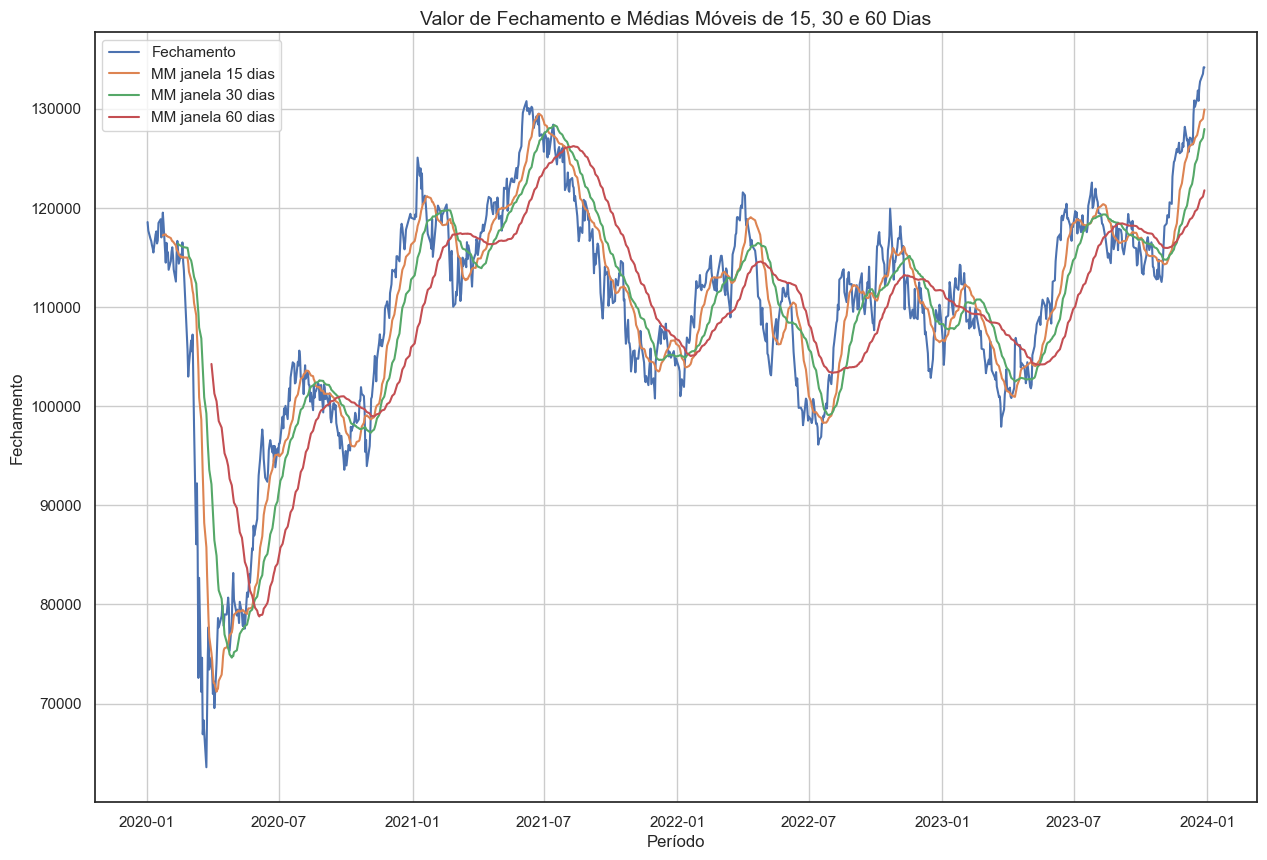

In [31]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_ibv_fecha['fechamento'], label='Fechamento')
plt.plot(df_ibv_fecha['mm_15'], label='MM janela 15 dias')
plt.plot(df_ibv_fecha['mm_30'], label='MM janela 30 dias')
plt.plot(df_ibv_fecha['mm_60'], label='MM janela 60 dias')
plt.title('Valor de Fechamento e Médias Móveis de 15, 30 e 60 Dias', fontsize=14)
plt.xlabel('Período')
plt.ylabel('Fechamento')
plt.legend(loc=2)
plt.show()

O modelo de média móvel, independentemente de ser para períodos de 15, 30 ou 60 dias, apresenta uma similaridade com a série temporal original. No entanto, não temos dados suficientes para afirmar que isso indica uma boa performance do modelo. Um desafio é que o gráfico cobre um período muito longo, o que torna difícil observar claramente o comportamento das três curvas devido à escala. Para uma análise mais detalhada, vamos focar no período de 2020, apresentando-o como um recorte do gráfico para examinar mais precisamente o comportamento das quatro curvas.

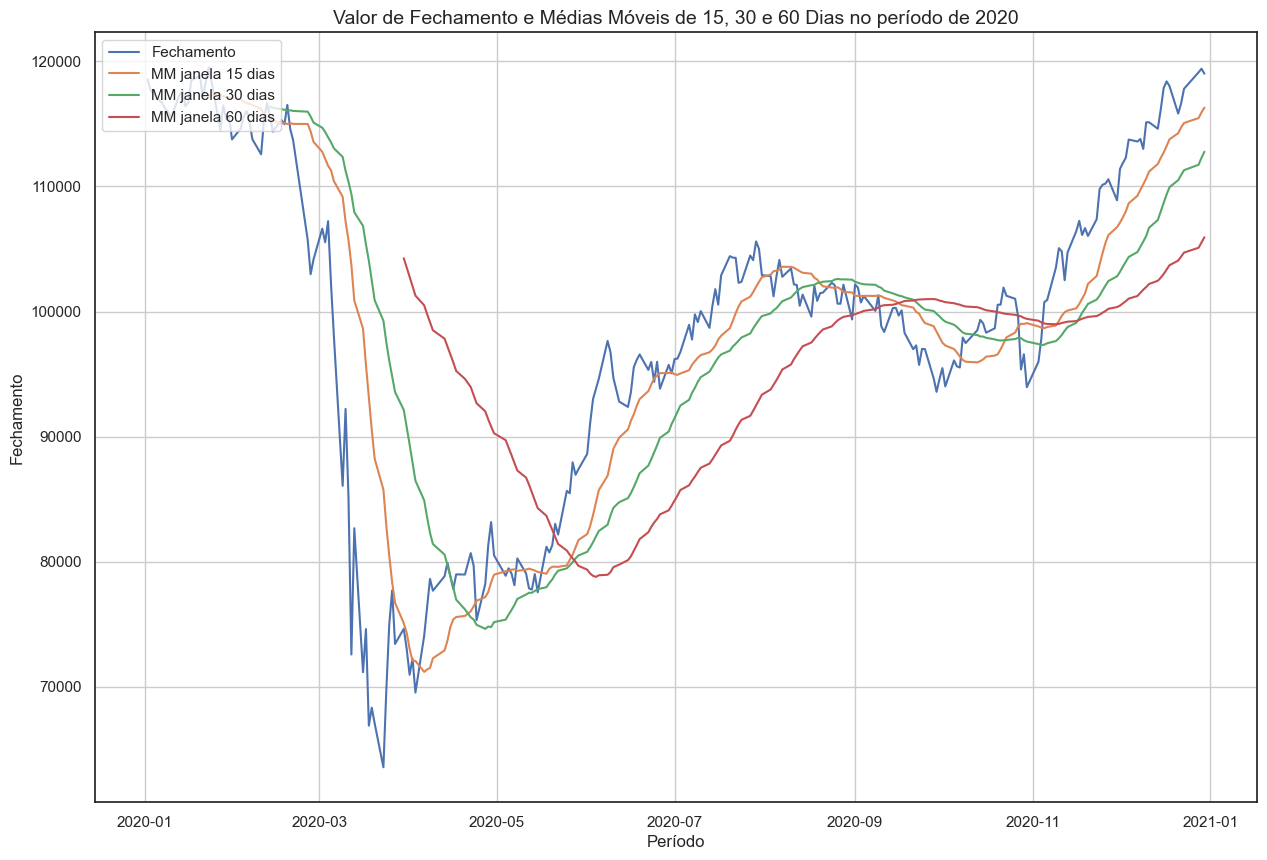

In [32]:
# Analise apenas de 2020 para melhor visualização
df_ibv_fecha_2020 = df_ibv_fecha.loc['2020-01-01':'2020-12-31']
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_ibv_fecha_2020['fechamento'], label='Fechamento')
plt.plot(df_ibv_fecha_2020['mm_15'], label='MM janela 15 dias')
plt.plot(df_ibv_fecha_2020['mm_30'], label='MM janela 30 dias')
plt.plot(df_ibv_fecha_2020['mm_60'], label='MM janela 60 dias')
plt.title('Valor de Fechamento e Médias Móveis de 15, 30 e 60 Dias no período de 2020', fontsize=14)
plt.xlabel('Período')
plt.ylabel('Fechamento')
plt.legend(loc=2)
plt.show()

Embora as curvas apresentem um direcionamento semelhante, os valores das curvas estão distantes entre si, o que indica que o modelo pode não estar apresentando uma boa performance.

#<font color=OrangeRed> Modelo ARIMA

O modelo ARIMA utiliza a combinação de média móvel, componentes auto-regressivos e diferenciação para descrever a autocorrelação nos dados. A parte auto-regressiva analisa os valores passados para prever futuros, a parte integrada indica o número de diferenciações aplicadas à série para torná-la estacionária, e a média móvel ajusta os erros de previsão para se aproximar de um valor constante. **Para aplicar o ARIMA, a série temporal deve ser necessariamente estacionária.** Sendo os principais hiperparâmetros do modelo ARIMA:

* p: Número de lags incluídos no modelo, representando os períodos passados usados para prever valores futuros.
* d: Número de vezes que a série será diferenciada para torná-la estacionária.
* q: Ordem da média móvel, indicando o tamanho da janela de erros passados utilizados para ajustar a previsão.

Em séries temporais, 'lag' refere-se ao atraso ou defasagem entre observações em diferentes períodos de tempo. No modelo ARIMA, P representa o número de lags auto-correlacionados usados para previsão, D indica o número de diferenciações aplicadas para tornar a série estacionária, e Q define a ordem da média móvel, que ajusta os erros da previsão.

Esses hiperparâmetros determinam a complexidade e a estrutura do modelo ARIMA e precisam ser ajustados para obter as melhores previsões para uma série temporal específica.

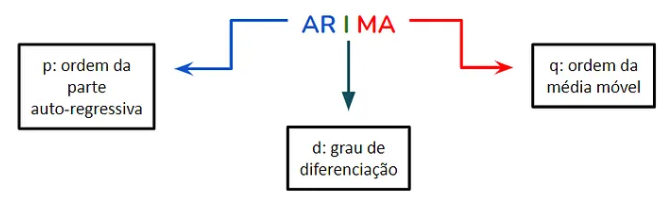

Figura: Resumo dos parâmetros modelo ARIMA.

Fonte Imagem: https://medium.com/data-hackers/series-temporais-parte-1-a0e75a512e72

#<font color=OrangeRed> Transformação da Série Temporal Original em Estacionária

In [33]:
df_ibv_fecha.head()

,fechamento,mm_15,mm_30,mm_60
data,,,,
2020-01-02,118573.0,NaN,NaN,NaN
2020-01-03,117707.0,NaN,NaN,NaN
2020-01-06,116878.0,NaN,NaN,NaN
2020-01-07,116662.0,NaN,NaN,NaN
2020-01-08,116247.0,NaN,NaN,NaN


Como demonstrado pelo teste ADF, nossa série temporal original não é estacionária. Portanto, para aplicar o modelo ARIMA, é necessário transformar a série em uma série estacionária. O primeiro passo nesse processo é analisar a média móvel.

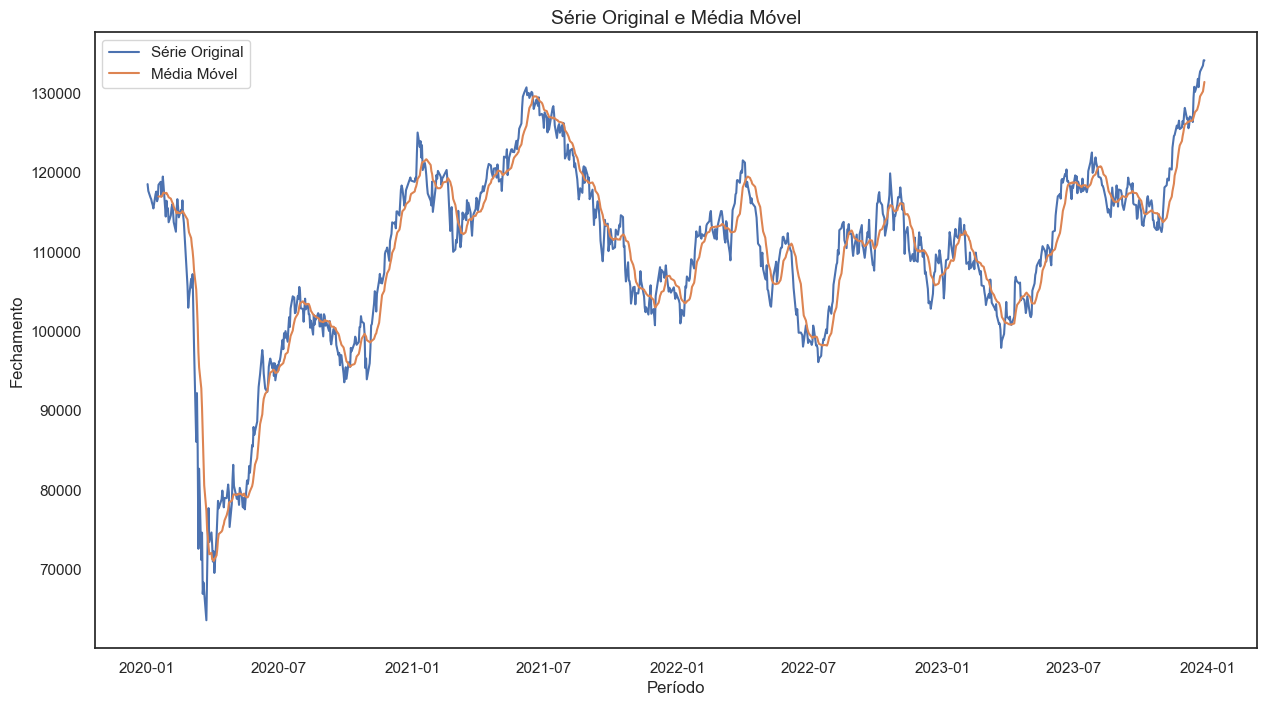

In [34]:
# Média Móvel para Modelo ARIMA
df_ibv_media = df_ibv_fecha['fechamento'].rolling(12).mean()  # Calculo da Média

plt.figure(figsize=(15,8))

serie_temp_orig = plt.plot(df_ibv_fecha['fechamento'], label='Série Original')
media_mov_fecha = plt.plot(df_ibv_media, label='Média Móvel')

plt.title('Série Original e Média Móvel', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)

plt.legend(loc='best')

plt.show()

Observa-se uma tendência na média móvel. Para corrigir isso, podemos aplicar uma escala logarítmica.

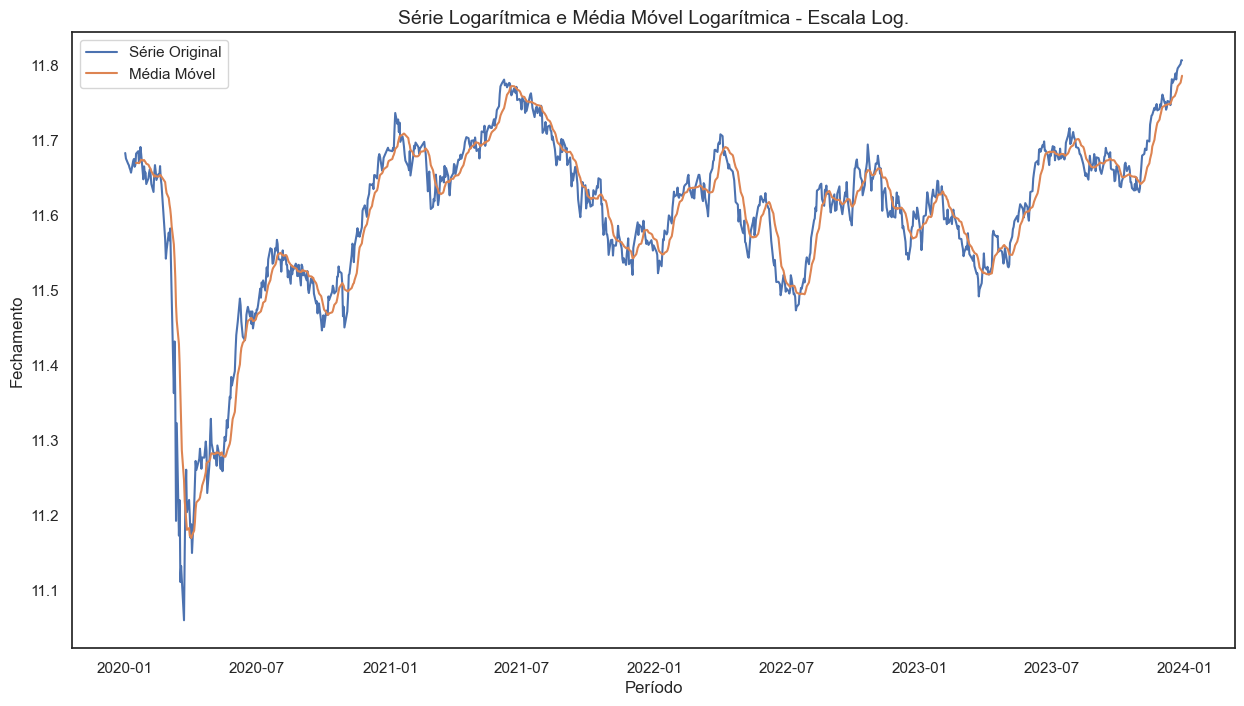

In [35]:
# Aplicação do Log

df_ibv_log = np.log(df_ibv_fecha['fechamento']) # Calculo do Logaritmo

df_med_log = df_ibv_log.rolling(12).mean()

plt.figure(figsize=(15,8))

serie_temp_orig_log = plt.plot(df_ibv_log, label='Série Original')
media_movel_log = plt.plot(df_med_log, label='Média Móvel')

plt.title('Série Logarítmica e Média Móvel Logarítmica - Escala Log.', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)

plt.legend(loc='best')

plt.show()

A princípio, não houve nenhuma mudança visível, mas ao observarmos o eixo Y, percebemos a alteração na escala dos valores. O próximo passo é remover a média móvel, o que nos ajudará a aproximar a série de um padrão estacionário.

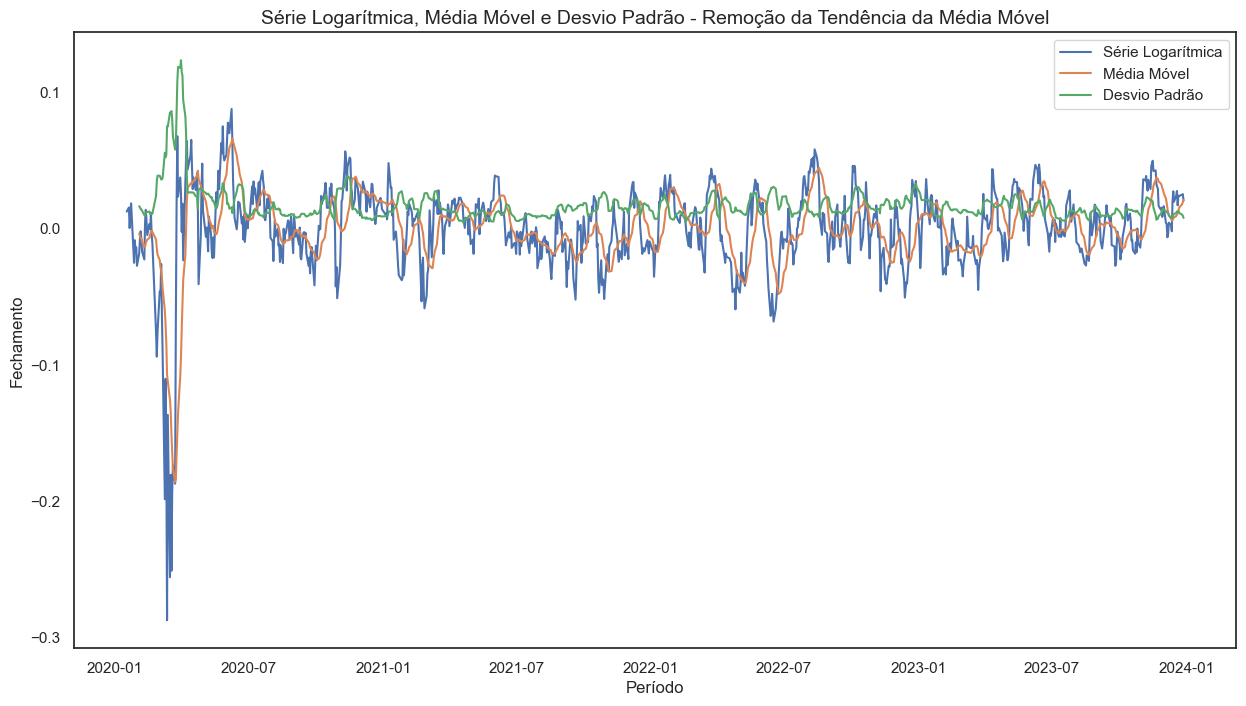

In [36]:
# Retirada da Média Móvel Log. para padrão estacionário

df_ibv_fecha_fim = (df_ibv_log - df_med_log).dropna() # remoção dos nulos

df_media = df_ibv_fecha_fim.rolling(12).mean()

df_des_p = df_ibv_fecha_fim.rolling(12).std()

plt.figure(figsize=(15,8))

serie_original_s = plt.plot(df_ibv_fecha_fim, label='Série Logarítmica')
media_movel_s = plt.plot(df_media, label='Média Móvel')
desvio_padrao_s = plt.plot(df_des_p, label='Desvio Padrão')

plt.title('Série Logarítmica, Média Móvel e Desvio Padrão - Remoção da Tendência da Média Móvel', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)

plt.legend(loc='best')

plt.show()

In [37]:
df_ibv_fecha_fim.head()

data
2020-01-17    0.012534
2020-01-20    0.015567
2020-01-21    0.000484
2020-01-22    0.011009
2020-01-23    0.018544
Name: fechamento, dtype: float64

In [38]:
# Aplicando novamente o Teste de Dickey-Fuller (ADF) após tratamento para regime estacionário

teste_adf_2 = df_ibv_fecha_fim.values

result = adfuller(teste_adf_2)

print('*****  Teste ADF 2 - Após Tratamento MM *****')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Valor: {result[1]}')
print(f'Valores Críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

*****  Teste ADF 2 - Após Tratamento MM *****
Teste Estatístico: -7.647629379133655
P-Valor: 1.8247231381899262e-11
Valores Críticos:
	1%: -3.43707471791689
	5%: -2.8645089073679597
	10%: -2.5683508010519396


Um valor p menor que 0,05 (5%) já nos garante que a nossa série é estacionária e aceitável. No entanto, podemos testar outras técnicas para melhorar a estacionariedade, já que no início da série ainda existe uma grande variação devido ao mês de março de 2020, quando o índice Bovespa sofreu a maior queda por conta da pandemia.

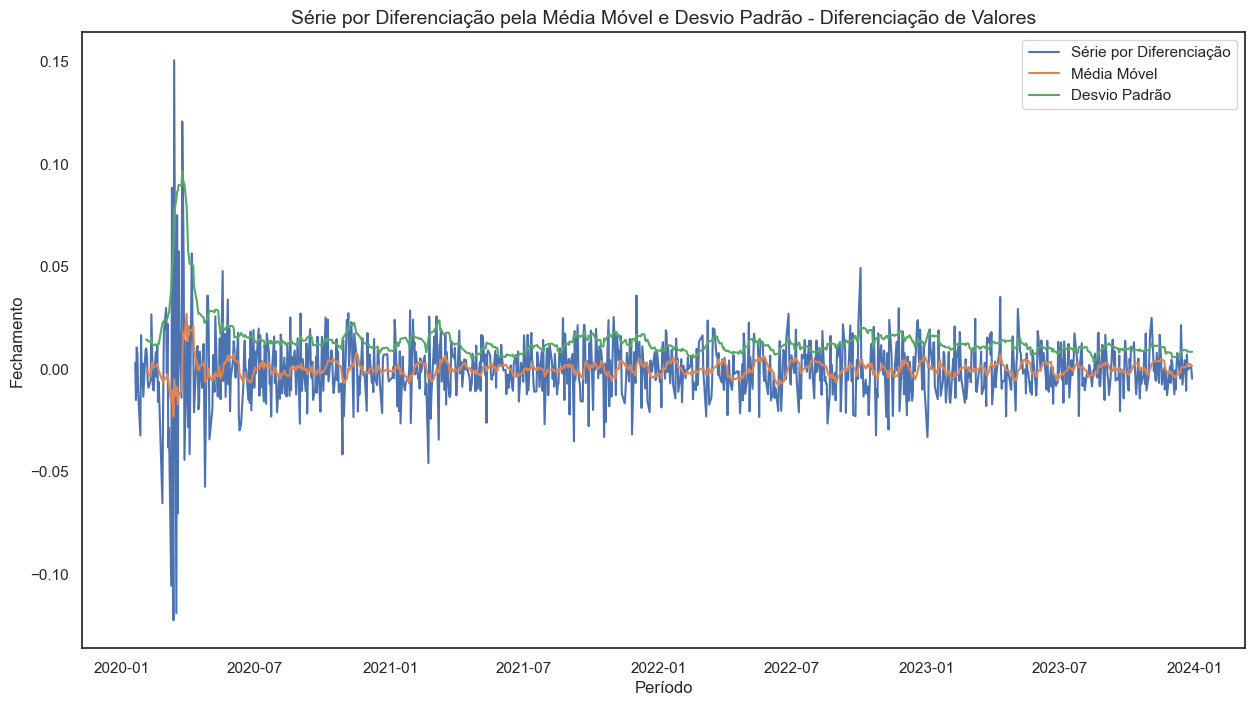

In [39]:
# Agora aplicando por Diferenciação

df_ibv_fecha_diff = df_ibv_fecha_fim.diff().dropna() # A diferença ocorre entre o valor anterior e o atual

df_media_diff = df_ibv_fecha_diff.rolling(12).mean()

df_des_p_diff = df_ibv_fecha_diff.rolling(12).std()

plt.figure(figsize=(15,8))

serie_original_s = plt.plot(df_ibv_fecha_diff, label='Série por Diferenciação')
media_movel_s = plt.plot(df_media_diff, label='Média Móvel')
desvio_padrao_s = plt.plot(df_des_p_diff, label='Desvio Padrão')
plt.title('Série por Diferenciação pela Média Móvel e Desvio Padrão - Diferenciação de Valores', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)

plt.legend(loc='best')

plt.show()

In [40]:
# Aplicando novamente o Teste de Dickey-Fuller (ADF) após tratamento por diferenciação

teste_adf_2 = df_ibv_fecha_diff.values

result = adfuller(teste_adf_2)

print('*****  Teste ADF 3 - Por Diferenciação *****')
print(f'Teste Estatístico: {result[0]}')
print(f'P-Valor: {result[1]}')
print(f'Valores Críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

*****  Teste ADF 3 - Por Diferenciação *****
Teste Estatístico: -10.273982883055286
P-Valor: 3.934374681567115e-18
Valores Críticos:
	1%: -3.4371729482129885
	5%: -2.8645522259969534
	10%: -2.568373874086242


Com isso, houve uma maior diminuição do valor p, indicando que nossa série está mais próxima de um estado estacionário.

# Análise por ACF e PACF

Temos que a **ACF (Autocorrelation Function)** mede a correlação entre uma série temporal e suas versões deslocadas em diferentes lags, sendo usada para identificar a ordem q do componente de média móvel (MA) do modelo ARIMA, enquanto a **PACF (Partial Autocorrelation Function)** mede a correlação entre a série e suas versões deslocadas, removendo a influência das observações intermediárias, e é usada para identificar a ordem p do componente autorregressivo (AR).


Se ambas as funções **ACF** e **PACF** decrescem rapidamente e cortam para zero após o primeiro lag, um modelo ARIMA(1, d, 1) pode ser adequado, onde d é a ordem de diferenciação necessária para tornar a série estacionária. O rápido declínio nas funções ACF e PACF indica que a série possui correlações significativas apenas em lags muito próximos, sugerindo a adequação de componentes de baixa ordem para AR e MA.

Para os limites críticos, utilizaremos a equação 1.96 / sqrt(N - d), onde N é o número de pontos do df e d é o número de vezes que diferenciamos o df. Neste projeto, diferenciamos o dataframe uma vez, portanto d=1.

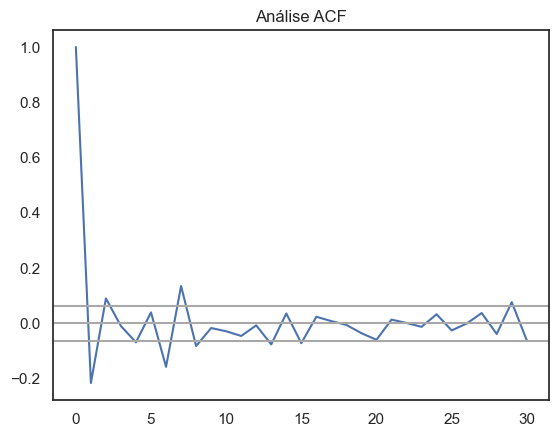

In [41]:
acf_lag = acf(df_ibv_fecha_diff.dropna(), nlags=30) # nlags = é a janela de tempo (dias)

plt.plot(acf_lag)

# Limites:
# inferior
plt.axhline(y = -1.96 / np.sqrt(len(df_ibv_fecha_diff) - 1), linestyle='-', color='DarkGray')

# centro
plt.axhline(y = 0, linestyle='-', color='DarkGray')

# superior
plt.axhline(y = 1.96 / np.sqrt(len(df_ibv_fecha_diff) - 1), linestyle='-', color='DarkGray')

plt.title('Análise ACF')
plt.show()

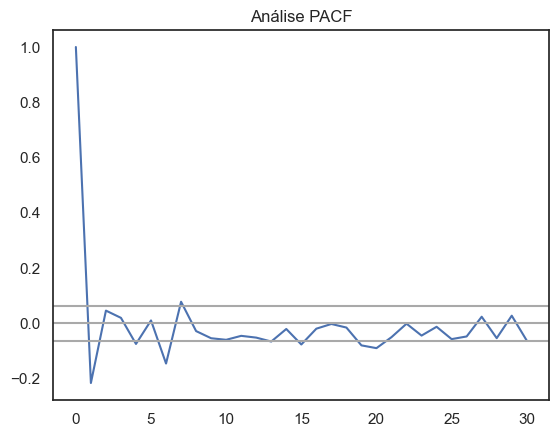

In [42]:
pacf_lag = pacf(df_ibv_fecha_diff.dropna(), nlags=30) # nlags = é a janela de tempo (dias)

plt.plot(pacf_lag)

# Limites:
# inferior
plt.axhline(y = -1.96 / np.sqrt(len(df_ibv_fecha_diff) - 1), linestyle='-', color='DarkGray')

# centro
plt.axhline(y = 0, linestyle='-', color='DarkGray')

# superior
plt.axhline(y = 1.96 / np.sqrt(len(df_ibv_fecha_diff) - 1), linestyle='-', color='DarkGray')

plt.title('Análise PACF')
plt.show()

Como observado, a ACF e a PACF apresentam picos acentuados no início, e com base na análise, serão considerados p e q iguais a 1. Portanto, para a construção do modelo ARIMA, utilizaremos o modelo ARIMA(1,1,1).

Temos a seguir outras opções de gráficos:


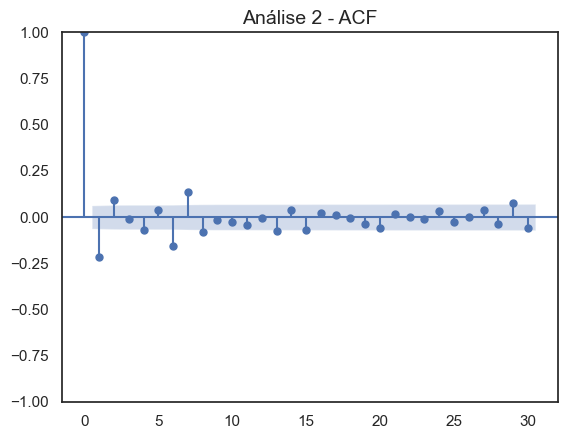

In [43]:
sm.graphics.tsa.plot_acf(df_ibv_fecha_diff, lags=30)

plt.title('Análise 2 - ACF', fontsize=14)

plt.show()

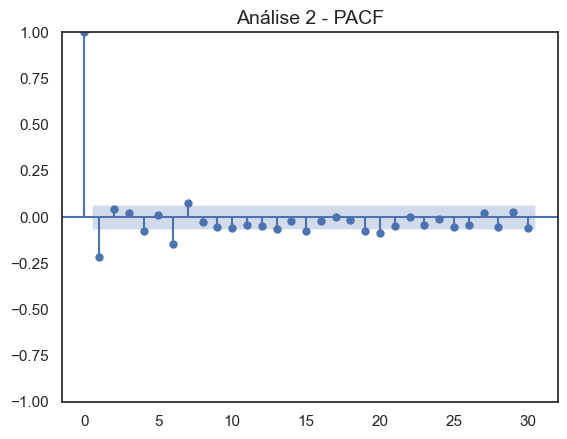

In [44]:
sm.graphics.tsa.plot_pacf(df_ibv_fecha_diff, lags=30)

plt.title('Análise 2 - PACF', fontsize=14)

plt.show()

#<font color=OrangeRed> Aplicação modelo ARIMA

Como discutido anteriormente, utilizaremos o modelo ARIMA(1,1,1). A seguir, apresentamos a chamada do modelo, os ajustes realizados, as previsões geradas e o cálculo do MAPE.

MAPE: 1153.85%


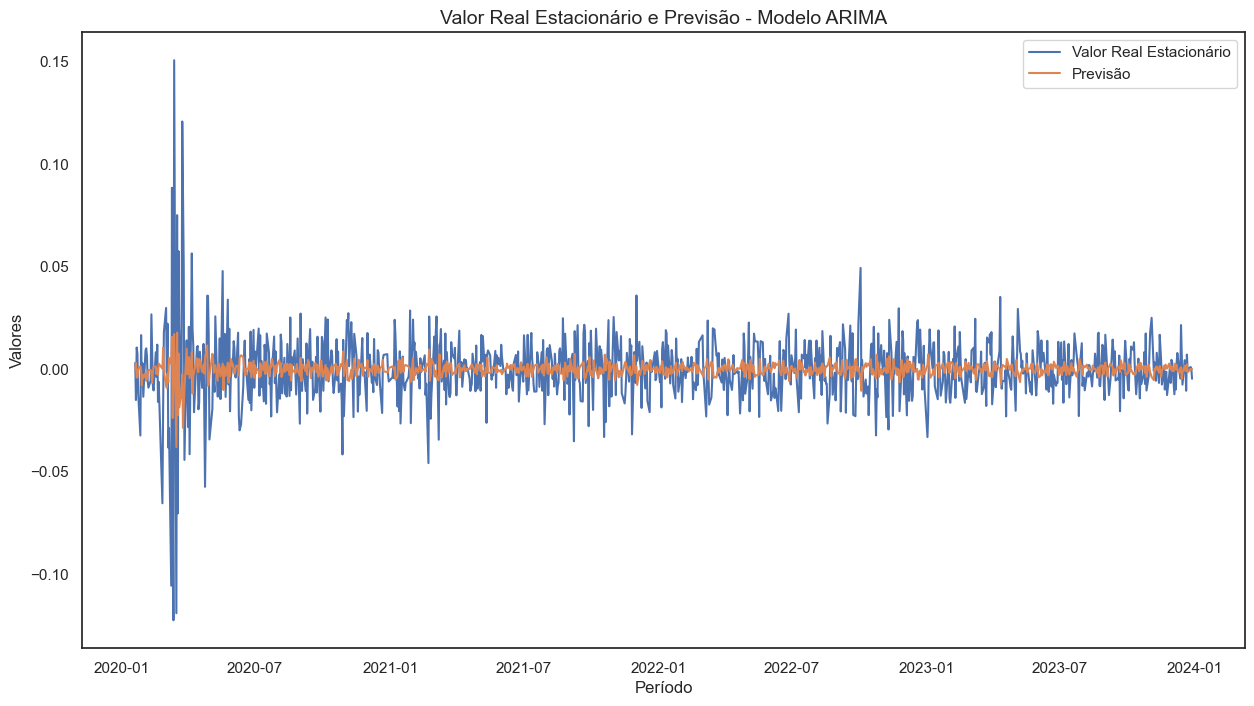

In [45]:
# Chamando o Modelo ARIMA
arima = ARIMA(df_ibv_fecha_diff, order=(1,1,1))


# Ajuste e e Predição do Modelo
resultado = arima.fit()
previsao = resultado.predict()

# Calculando o MAPE
previsao.index = df_ibv_fecha_diff.index # Ajuste do índice
valores_previsao = df_ibv_log.iloc[0] + np.cumsum(previsao) # Invertendo para a diferenciação
mape = mean_absolute_error(df_ibv_fecha_diff, valores_previsao) * 100
print(f"MAPE: {mape:.2f}%")

# Comparação entre o Valor Real e Previsão
plt.figure(figsize=(15,8))
plt.plot(df_ibv_fecha_diff)
plt.plot(previsao)
plt.legend(labels=['Valor Real Estacionário','Previsão'], loc='best')
plt.title('Valor Real Estacionário e Previsão - Modelo ARIMA', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.show()



O **MAPE (Mean Absolute Percentage Error)** é uma métrica que calcula o erro percentual médio absoluto. É amplamente utilizado para avaliar modelos de séries temporais, como o **ARIMA**. Quanto mais próximo de zero, melhor é o desempenho do modelo. No **ARIMA** testado, observamos um desempenho insatisfatório, como evidenciado pelo gráfico que mostra a discrepância significativa entre as previsões e os valores reais. O valor do MAPE(1153.85%) confirma essa conclusão.

# <font color=Aquamarine> Modelo Naive

O **modelo Naive** é uma técnica simples de previsão de séries temporais que assume que o valor futuro será igual ao valor mais recente observado. Em vez de usar padrões históricos ou tendências, ele baseia-se apenas no valor atual para prever o próximo período. Temos essa abordagem útil para séries sem grande complexidade e serve como uma referência básica para comparar com modelos mais avançados.

Foi utilizado o pacote StatsForecast para aplicar o modelo. Na tentativa de melhorar a performance, foi selecionado um período de tempo menor da série temporal para treino e validação. Além disso, foi necessário ajustar os nomes das colunas da série temporal para atender aos requisitos da biblioteca StatsForecast.

In [46]:
df_ibv_fecha_diff.head()

data
2020-01-20    0.003033
2020-01-21   -0.015083
2020-01-22    0.010525
2020-01-23    0.007535
2020-01-24   -0.011197
Name: fechamento, dtype: float64

In [47]:
df_ibv_fecha_nv = df_ibv_fecha_diff.reset_index().rename(columns={'data': 'ds', 'fechamento': 'y'})
df_ibv_fecha_nv['unique_id'] = 1.0
df_ibv_fecha_nv.head()

,ds,y,unique_id
0,2020-01-20,0.003033,1.0
1,2020-01-21,-0.015083,1.0
2,2020-01-22,0.010525,1.0
3,2020-01-23,0.007535,1.0
4,2020-01-24,-0.011197,1.0


Para o treino temos o seguinte período (09/2022 - 09/2023):

In [48]:
treino = df_ibv_fecha_nv[(df_ibv_fecha_nv['ds'] >= '2022-09-01') & (df_ibv_fecha_nv['ds'] < '2023-09-01')] # treino 80%
treino.head()

,ds,y,unique_id
652,2022-09-01,0.010334,1.0
653,2022-09-02,0.006260,1.0
654,2022-09-05,0.013193,1.0
655,2022-09-06,-0.020672,1.0
656,2022-09-08,0.001826,1.0


Já para a validação temos o seguinte período (09/2023 - 11/2023):

In [49]:
validacao = df_ibv_fecha_nv[(df_ibv_fecha_nv['ds'] >= '2023-09-01') & (df_ibv_fecha_nv['ds'] < '2023-12-02')] # validacao 20%
validacao.head()

,ds,y,unique_id
902,2023-09-01,0.016771,1.0
903,2023-09-04,-0.002986,1.0
904,2023-09-05,-0.005170,1.0
905,2023-09-06,-0.012664,1.0
906,2023-09-08,-0.005204,1.0


In [50]:
h = validacao['ds'].nunique() # horizonte
h

62

Após o tratamento, temos abaixo a aplicação do modelo:

Valor do MAPE: 157.19%


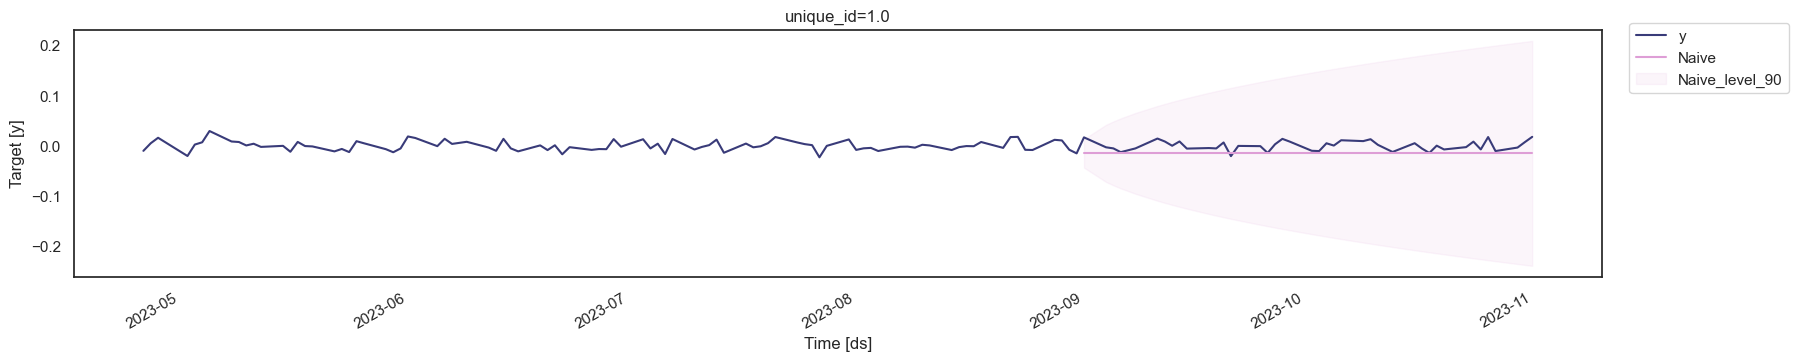

In [51]:
# Chamando o Modelo
mod_naive = StatsForecast(models=[Naive()], freq='D', n_jobs=-1) # variável freq frequencia em dia (D de diária) | n_jobs-1 - padronizado, está relacionado com a performance

# Treinamento e Predição do modelo
mod_naive.fit(treino)
previsao_nv = mod_naive.predict(h=h, level=[90])
# h - horizonte
# level - nível de confiança (%)

# Construção do Df para as previsões
df_previsao_nv = previsao_nv.reset_index().merge(validacao, on=['ds', 'unique_id'], how='left').dropna()

# MAPE
mape_naive = mean_absolute_error(df_previsao_nv['y'].values, df_previsao_nv['Naive'].values) * 100
print(f"Valor do MAPE: {mape_naive:.2%}")

# Plot do gráfico
mod_naive.plot(treino,
           df_previsao_nv,
           level=[90],
           unique_ids=[1.0],
           engine='matplotlib',
           max_insample_length=90)

Como observado, o MAPE permanece alto, indicando uma performance insatisfatória (MAPE 157.19%). Embora o modelo Naive tenha mostrado uma melhoria em relação ao ARIMA, é importante notar que o Naive utiliza apenas um ano de dados para prever três meses, enquanto o ARIMA considera toda a base de dados de uma só vez.

# <font color=DeepPink>   Modelo Seasonal Naive

O **modelo Seasonal Naive** é uma variante do **modelo Naive** que leva em conta a sazonalidade nos dados temporais. Em vez de prever o próximo valor com base no valor mais recente, o Seasonal Naive utiliza o valor correspondente do mesmo período da temporada anterior. Isso o torna mais adequado para séries com padrões sazonais regulares, enquanto o modelo Naive, que apenas usa o valor mais recente para previsão, não considera esses padrões sazonais. Abaixo, temos a aplicação do modelo:

Valor do MAPE: 131.65%


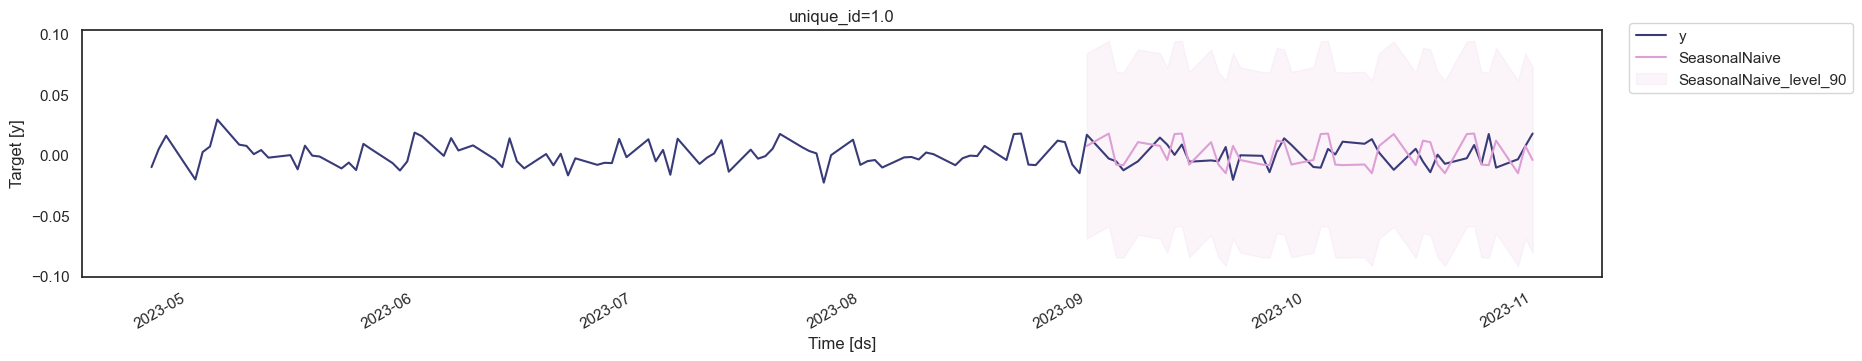

In [52]:
# Chamando o Modelo
mod_sas_naive = StatsForecast(models=[SeasonalNaive(season_length=10)], freq='D', n_jobs=-1) # season_lenght - comprimento da janela sazonal

# Treinamento e Predição do modelo
mod_sas_naive.fit(treino)
previsao_sas_naive = mod_sas_naive.predict(h=h, level=[90])

# Construção do Df para as previsões
df_previsao_sas_naive = previsao_sas_naive.reset_index().merge(validacao, on=['ds', 'unique_id'], how='left').dropna()

# MAPE
mape_sas_naive = mean_absolute_error(df_previsao_sas_naive['y'].values, df_previsao_sas_naive['SeasonalNaive'].values) * 100
print(f"Valor do MAPE: {mape_sas_naive:.2%}")

# Plot do gráfico
mod_sas_naive.plot(treino,
           df_previsao_sas_naive,
           level=[90],
           unique_ids=[1.0],
           engine='matplotlib',
           max_insample_length=90)

A adição do componente sazonal com o novo modelo resultou em uma redução do MAPE, mas a queda não foi significativa e a performance ainda não é satisfatória (MAPE 131.65%).

-----------------------------------------------------------------------------

# <font color=Yellow>   Modelo Seasonal Windown Average

**PARTE NOVA - EXPLICAR**

                  ds    SeasWA
unique_id                     
1.0       2023-09-01  0.006082
1.0       2023-09-02 -0.001944
1.0       2023-09-03 -0.000924
1.0       2023-09-04  0.001567
1.0       2023-09-05 -0.001960
Index(['unique_id', 'ds', 'SeasWA', 'y'], dtype='object')
Valor do MAPE: 81.16%


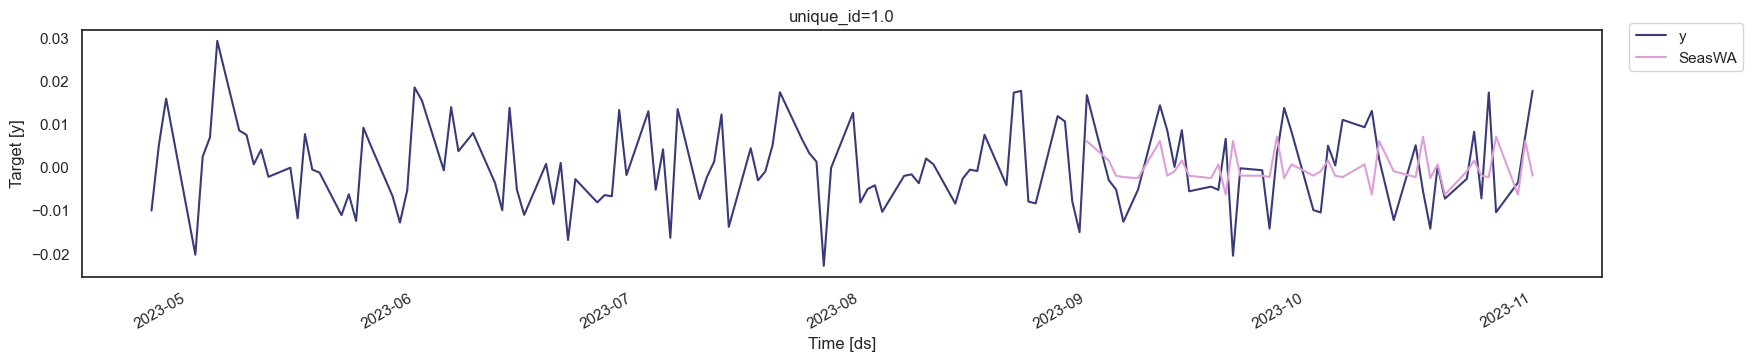

In [53]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Chamando o Modelo SeasonalWindowAverage
mod_seasonal_window_avg = StatsForecast(
    models=[SeasonalWindowAverage(season_length=10, window_size=7)],  # season_length - comprimento da janela sazonal, window_size - tamanho da janela de média móvel
    freq='D',
    n_jobs=-1
)

# Treinamento e Predição do modelo
mod_seasonal_window_avg.fit(treino)
previsao_seasonal_window_avg = mod_seasonal_window_avg.predict(h=h)

# Verificar a estrutura do DataFrame de previsão
print(previsao_seasonal_window_avg.head())

# Construção do DataFrame para as previsões
df_previsao_seasonal_window_avg = previsao_seasonal_window_avg.reset_index().merge(validacao, on=['ds', 'unique_id'], how='left').dropna()

# Verificar o nome das colunas no DataFrame
print(df_previsao_seasonal_window_avg.columns)

# MAPE
mape_seasonal_window_avg = mean_absolute_error(df_previsao_seasonal_window_avg['y'].values, df_previsao_seasonal_window_avg['SeasWA'].values) * 100
print(f"Valor do MAPE: {mape_seasonal_window_avg:.2%}")

# Plot do gráfico
mod_seasonal_window_avg.plot(treino,
                             df_previsao_seasonal_window_avg,
                             unique_ids=[1.0],
                             engine='matplotlib',
                             max_insample_length=90)

# <font color=Tomato>    Modelo com Prophet

O **modelo Prophet**, criado pelo Facebook, é uma ferramenta de previsão de séries temporais que lida com tendências, sazonalidades e feriados. Ele decompõe os dados em componentes aditivos e é robusto a dados ausentes e mudanças abruptas, tornando-o eficaz para previsões de longo prazo com padrões sazonais complexos.

Para o tratamento dos dados, temos a necessidade de modificar os nomes das colunas por conta do modelo:

In [54]:
df_ibov = grouped_data_ibovespa[['Último', 'Data']].set_index('Data').sort_index()
df_prophet = df_ibov.reset_index()
df_prophet[['ds','y']] = df_prophet[['Data', 'Último']]
df_prophet.head()

,Data,Último,ds,y
0,2020-01-02,118573.0,2020-01-02,118573.0
1,2020-01-03,117707.0,2020-01-03,117707.0
2,2020-01-06,116878.0,2020-01-06,116878.0
3,2020-01-07,116662.0,2020-01-07,116662.0
4,2020-01-08,116247.0,2020-01-08,116247.0


Para o treino e teste, temos:

In [55]:
treino = df_prophet.sample(frac=0.8, random_state=0)
teste = df_prophet.drop(treino.index)
print(f'training data size : {treino.shape}')
print(f'testing data size : {teste.shape}')

training data size : (795, 4)
testing data size : (199, 4)


In [58]:
# Chamando o Modelo
mod_prophet = Prophet(daily_seasonality=True)

# Treinamento e Predição do modelo
mod_prophet.fit(treino)
df_prev_prophet = mod_prophet.make_future_dataframe(periods=30, freq='D')
previsao_prophet = mod_prophet.predict(df_prev_prophet)

# Construção do Df para as previsões
previsao_col = ['ds', 'yhat']
valor_real_col = ['ds', 'y']
previsao = previsao_prophet[previsao_col]
val_real = treino[valor_real_col]
resultados = pd.merge(previsao, val_real, on='ds', how='inner')

# Calculo do erro percentual absoluto para cada ponto dos dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])
print(f"MAPE: {mape:.2f}%")

# Plot do gráfico
plt.figure(figsize=(15,8))
mod_prophet.plot(previsao_prophet);
plt.plot(teste['ds'], teste['y'], '.r')
plt.title('Aplicação Modelo Prophet', fontsize=14)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.show()

AttributeError: 'Prophet' object has no attribute 'stan_backend'

Entre todos os modelos avaliados (MAPE: 3.40%), o Prophet apresentou o melhor desempenho. Sendo uma ferramenta mais robusta, sua performance superior em comparação com modelos mais simples era esperada.